# Initial protype of the Euler inversion code

In [1]:
import numpy as np
from scipy import sparse
import scipy
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.default_rng(0)

In [3]:
region = [75e3, 150e3, 160e3, 250e3]
height = 1500
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(50, 50), extra_coords=height)]
x, y, z = coordinates
center = [[110e3], [200e3], [-5e3]]
mass = [200 * 4 / 3 * np.pi * np.abs(center[2][0]) ** 3]
base_level = 0
field = hm.point_gravity(coordinates, center, mass, field="g_z") + base_level
delta = 1
xderiv = (
    hm.point_gravity((x + delta, y, z), center, mass, field="g_z")
    - hm.point_gravity((x - delta, y, z), center, mass, field="g_z")
) / 2 * delta
yderiv = (
    hm.point_gravity((x, y + delta, z), center, mass, field="g_z")
    - hm.point_gravity((x, y - delta, z), center, mass, field="g_z")
) / 2 * delta
zderiv = (
    hm.point_gravity((x, y, z + delta), center, mass, field="g_z")
    - hm.point_gravity((x, y, z - delta), center, mass, field="g_z")
) / 2 * delta


field += random.normal(loc=0, scale=0.5, size=field.size)
xderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
yderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
zderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)

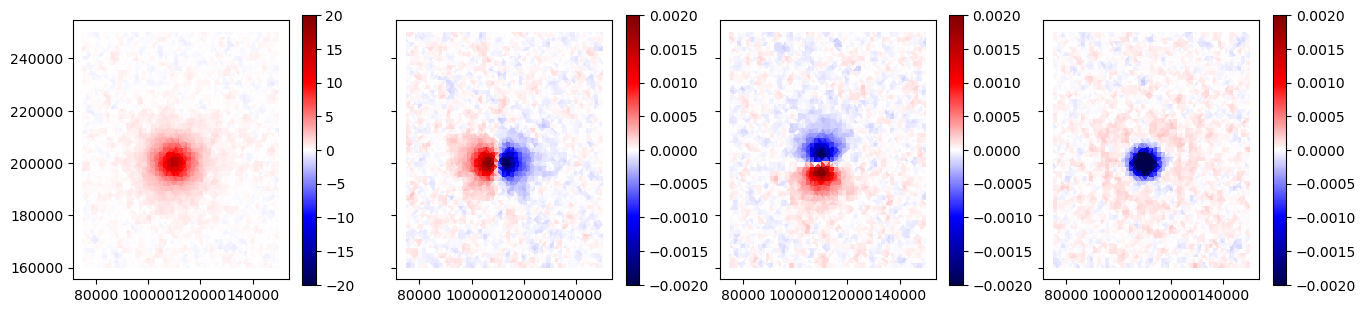

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, field, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
ax.set_aspect("equal")
for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    ax.set_aspect("equal")
    plt.colorbar(tmp)

## Calculate the matrices involved

In [5]:
def jacobian_parameters(xderiv, yderiv, zderiv, structural_index):
    """
    Calculate the model parameter Jacobian.
    """
    jacobian = np.empty((xderiv.size, 4))
    jacobian[:, 0] = -xderiv
    jacobian[:, 1] = -yderiv
    jacobian[:, 2] = -zderiv
    jacobian[:, 3] = -structural_index
    return jacobian

In [6]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = sparse.hstack(
        [
            sparse.diags(np.full(nequations, structural_index)),
            sparse.diags(x - xo),
            sparse.diags(y - yo),
            sparse.diags(z - zo),
        ],
        format="csc",
    )
    return jacobian

In [7]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [12]:
def gauss_newton_step(parameters, data, coordinates, data_observed, Wd_inv, structural_index):
    """
    Take a step in Gauss-Newton and return new parameters and data.
    """
    x, y, z = coordinates
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, base_level = parameters
    A = jacobian_parameters(dx, dy, dz, structural_index)
    B = jacobian_data(x, y, z, xo, yo, zo, structural_index)
    r = data_observed - data
    f = eulers_equation(x, y, z, data, parameters, structural_index)
    Q = B @ Wd_inv @ B.T
    Q_inv = sparse.linalg.inv(Q)
    ATQ = A.T @ Q_inv
    BTQ = B.T @ Q_inv
    Br = B @ r
    Wd_invBTQ = Wd_inv @ BTQ
    deltap = np.linalg.solve(
        ATQ @ A,
        -ATQ @ (f + Br)
    )
    deltad = r - Wd_invBTQ @ Br - Wd_invBTQ @ (f + A @ deltap)
    return deltap, deltad

In [42]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index, maxit=50, tol=1e-7):
    """
    """
    region = vd.get_region(coordinates)
    deast, dnorth = (region[1] - region[0]), (region[3] - region[2])
    area = deast * dnorth
    data_observed = np.concatenate([field, xderiv, yderiv, zderiv])
        
    parameters = np.array([
        0.5 * (region[1] + region[0]),
        0.5 * (region[3] + region[2]),
        0,
        0,
    ])
    data = 0.5 * np.copy(data_observed)
    #data = np.random.uniform(0, 1, data_observed.size)
    
    wd = np.concatenate([
        np.full_like(field, 1 / np.linalg.norm(field)),
        np.full_like(field, 1 / np.linalg.norm(xderiv)),
        np.full_like(field, 1 / np.linalg.norm(yderiv)),
        np.full_like(field, 1 / np.linalg.norm(zderiv)),
    ])
    Wd_inv = sparse.diags(1 / wd ** 2, format="csc")

    euler = eulers_equation(*coordinates, data, parameters, structural_index)
    euler_misfit = np.sum(np.abs(euler))
    misfit = np.linalg.norm((data_observed - data) * wd)
    merit = misfit**2 + np.sum(np.abs(euler))
    print(f"Initial state | Euler: {euler_misfit:.3f} | misfit: {misfit:.3f} | merit: {merit:.3f}")
    
    for i in range(maxit):
        deltap, deltad = gauss_newton_step(
            parameters,
            data, 
            coordinates, 
            data_observed, 
            Wd_inv, 
            structural_index,
        )
        alpha = 1
        for j in range(1):
            misfit = np.linalg.norm((data_observed - (data + alpha * deltad)) * wd)
            euler = eulers_equation(*coordinates, data + alpha * deltad, parameters + alpha * deltap, structural_index)
            new_merit = misfit**2 +  np.sum(np.abs(euler))
            if new_merit < merit:
                break
            else:
                alpha /= 10
        if new_merit > merit:
            print("Increase")
            break
        parameters += alpha * deltap
        data += alpha * deltad
        merit_change = abs((merit - new_merit) / merit)
        merit = new_merit
        euler_misfit = np.sum(np.abs(euler))
        misfit = np.linalg.norm((data_observed - data) * wd)
        print(f"  Euler: {euler_misfit:.3e} | data: {misfit:.3e} | merit: {merit:.3e} | line search: {j}")
        if merit_change < tol:
            break
    field_pred, dx_pred, dy_pred, dz_pred = np.split(data, 4)
    return parameters, field_pred, dx_pred, dy_pred, dz_pred

In [43]:
def euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index):
    x, y, z = coordinates
    A = np.stack([xderiv, yderiv, zderiv, np.full_like(field, structural_index)], axis=1)
    d = x * xderiv + y * yderiv + z * zderiv + structural_index * field
    parameters = np.linalg.solve(A.T @ A, A.T @ d)
    return parameters

In [44]:
structural_index = 2
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

Initial state | Euler: 3799.316 | misfit: 1.000 | merit: 3800.316
  Euler: 2.144e+03 | data: 4.221e-01 | merit: 2.144e+03 | line search: 0
  Euler: 4.829e+02 | data: 3.777e-01 | merit: 4.830e+02 | line search: 0
  Euler: 1.605e+01 | data: 4.000e-01 | merit: 1.621e+01 | line search: 0
  Euler: 6.180e-01 | data: 4.007e-01 | merit: 7.786e-01 | line search: 0
  Euler: 2.090e-02 | data: 4.007e-01 | merit: 1.815e-01 | line search: 0
  Euler: 8.953e-04 | data: 4.007e-01 | merit: 1.615e-01 | line search: 0
  Euler: 2.995e-05 | data: 4.007e-01 | merit: 1.606e-01 | line search: 0
  Euler: 1.297e-06 | data: 4.007e-01 | merit: 1.606e-01 | line search: 0
  Euler: 4.429e-08 | data: 4.007e-01 | merit: 1.606e-01 | line search: 0
  Euler: 1.934e-09 | data: 4.007e-01 | merit: 1.606e-01 | line search: 0
  Euler: 6.683e-11 | data: 4.007e-01 | merit: 1.606e-01 | line search: 0

         True: 110000.0 200000.0 -5000.0 0.0
    Inversion: 110093.3 199771.5 -5018.4 -0.0
Devoncolution: 110615.4 200629.0 -4241.

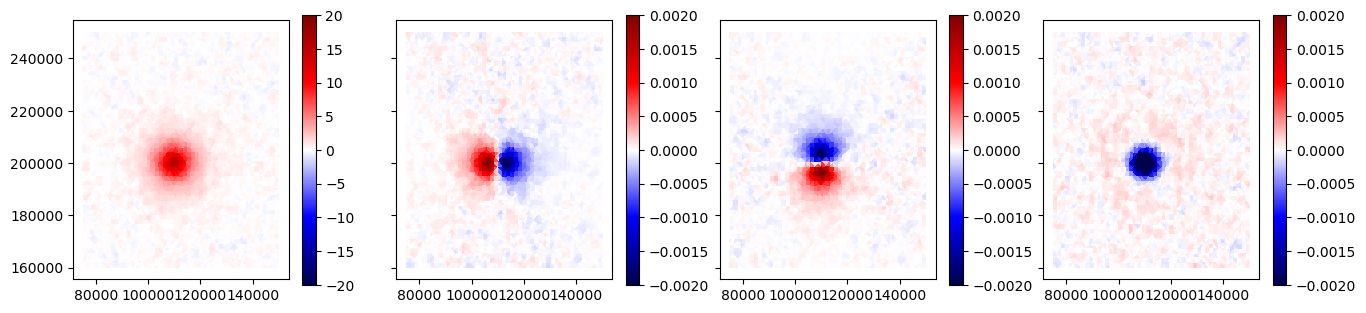

In [45]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, d + p[-1], cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
ax.set_aspect("equal")
for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    ax.set_aspect("equal")
    plt.colorbar(tmp)

In [17]:
structural_index = 1
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

Initial state | Euler: 38652097.376 | misfit: 3892.737 | merit: 53805495.475
  Euler: 1.764e+03 | data: 6.895e-01 | merit: 1.764e+03 | line search: 0
  Euler: 2.993e+02 | data: 5.308e-01 | merit: 2.996e+02 | line search: 0
  Euler: 8.223e+00 | data: 4.853e-01 | merit: 8.459e+00 | line search: 0
  Euler: 1.653e+00 | data: 4.823e-01 | merit: 1.885e+00 | line search: 0
  Euler: 1.866e-01 | data: 4.819e-01 | merit: 4.188e-01 | line search: 0
  Euler: 2.057e-02 | data: 4.818e-01 | merit: 2.527e-01 | line search: 0
  Euler: 2.250e-03 | data: 4.818e-01 | merit: 2.344e-01 | line search: 0
  Euler: 2.406e-04 | data: 4.818e-01 | merit: 2.324e-01 | line search: 0
  Euler: 2.591e-05 | data: 4.818e-01 | merit: 2.322e-01 | line search: 0

         True: 110000.0 200000.0 -5000.0 0.0
    Inversion: 109986.5 199852.9 -1209.1 -1.4
Devoncolution: 110523.3 200687.4 -391.3 -0.5



In [18]:
structural_index = 3
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

Initial state | Euler: 39010870.899 | misfit: 3873.614 | merit: 54015753.758
  Euler: 4.453e+02 | data: 7.086e-01 | merit: 4.458e+02 | line search: 0
  Euler: 2.310e+02 | data: 4.238e-01 | merit: 2.312e+02 | line search: 0
  Euler: 4.023e+00 | data: 4.010e-01 | merit: 4.184e+00 | line search: 0
  Euler: 2.601e+00 | data: 3.997e-01 | merit: 2.761e+00 | line search: 0
  Euler: 6.339e-02 | data: 3.996e-01 | merit: 2.231e-01 | line search: 0
  Euler: 1.137e-02 | data: 3.996e-01 | merit: 1.711e-01 | line search: 0
  Euler: 3.703e-04 | data: 3.996e-01 | merit: 1.601e-01 | line search: 0
  Euler: 4.950e-05 | data: 3.996e-01 | merit: 1.597e-01 | line search: 0
  Euler: 1.969e-06 | data: 3.996e-01 | merit: 1.597e-01 | line search: 0

         True: 110000.0 200000.0 -5000.0 0.0
    Inversion: 110241.1 199664.7 -9409.2 0.3
Devoncolution: 110707.5 200570.6 -8092.0 0.2

